In [2]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import time
import sys
import os

import seaborn as sns
import gensim

import django
import platform

if platform.node() == "srv-mcc-apsis":
    sys.path.append('/home/leey/tmv/BasicBrowser/')
else:
    # local paths
    sys.path.append('/home/leey/Documents/Data/tmv/BasicBrowser/')

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

# import from appended path
import parliament.models as pm
from parliament.tasks import do_search, run_tm
import cities.models as cmodels
from django.contrib.auth.models import User
from tmv_app.models import *
from utils.tm_mgmt import update_topic_scores
from utils.text import *
from django.db.models import Q, Count, Func, F, Sum, Value, Case, When, IntegerField

from parliament.utils import merge_utterance_paragraphs
# for sentence splitting
import nltk.data

In [4]:
uts = pm.Utterance.objects.filter(search_matches__pk=89).order_by('id')
texts, docsizes, ids = merge_utterance_paragraphs(uts)

In [16]:
s = pm.Search.objects.get(id=103)
# show all fields in a model: pm.Search._meta.fields
regex = s.text
SEARCH = re.compile(regex, re.IGNORECASE)
sentence_tokenizer = nltk.data.load('tokenizers/punkt/german.pickle')

matched_sentences = []

for text in texts:
    sentences = sentence_tokenizer.tokenize(text)
    for sentence in sentences:
        if SEARCH.search(sentence):
            matched_sentences.append(sentence)

print("found {} matched sentences in {} speeches".format(len(matched_sentences), len(texts)))

found 27444 matched sentences


In [17]:
matched_sentences

['Eigentlich hätte er doch die Steinkohle erwähnen müssen, nicht wahr.',
 'Herr Kollege Fischer, ich wollte mich nur vergewissern, ob ich Sie wirklich richtig verstanden habe: Haben Sie eben zum Ausdruck bringen wollen, daß die der Steinkohle zugesagten Subventionen,\ndaß die Subventionen für die Werften, daß die Subventionen für die deutsche Landwirtschaft allesamt Subventionen für Großverdiener sind?',
 'Die Klientel, die Sie beschützen wollen, hängt in der Tat nicht von Steinkohlesubventionen ab, hängt nicht von Landwirtschaftssubventionen ab -- wobei die Dinge hier schon etwas anders aussehen -- und hängt nicht von Werftensubventionen ab, sondern die hängt davon ab, daß sie nominell hohe Spitzensteuersätze in diesem Lande umgehen kann.',
 'Ich weiß doch, daß Sie die Kohle brauchen, wenn Sie die Kernkraftwerke abschalten wollen.',
 'Jetzt habe ich als Ministerpräsident von Baden-Württemberg wirklich jahrelang darum gekämpft, daß der Kohlepfennig abgeschafft wird.',
 'Herr Teufel, we

In [ ]:
matched_sentences_withoutnl = [sentence.replace("\n", " ") for sentence in matched_sentences]

In [1]:
filename = "data/all_sentences_with_Kohle_withoutnl.txt"

In [ ]:
# write sentences to file

file = open(filename, "w")
file.write("\n".join(matched_sentences_withoutnl))
file.close()

In [3]:
# read sentences from file

file = open(filename, "r")
lines = file.readlines()
file.close()
matched_sentences_withoutnl = [line.replace("\n", "") for line in lines]
matched_sentences_withoutnl

# compounds and their frequencies

In [23]:
re_kohle = "\w*kohle\w*"
SEARCH = re.compile(re_kohle, re.IGNORECASE)

count_coal_compounds = {}

for sentence in matched_sentences:
    for match in SEARCH.findall(sentence):
        if match in count_coal_compounds.keys():
            count_coal_compounds[match] += 1
        else:
            count_coal_compounds[match] = 1

In [28]:
count_coal_compounds.keys()

dict_keys(['Steinkohle', 'Steinkohlesubventionen', 'Kohle', 'Kohlepfennig', 'Kohlepfennigs', 'Kohlesubventionen', 'Kohleförderung', 'Steinkohleverstromung', 'Braunkohle', 'Braunkohleabbau', 'Kohlelieferungen', 'Kohlekraftwerk', 'Braunkohlefolgelandschaften', 'Braunkohlesanierung', 'Braunkohleausschusses', 'Braunkohletagebau', 'Braunkohlebergbau', 'Braunkohletagebaus', 'Kohlebereich', 'Kohlekraftwerken', 'Steinkohlenbergwerken', 'Aktivkohlefilter', 'Kohleeffizienz', 'Importkohle', 'Steinkohleblöcke', 'Steinkohleförderung', 'Braunkohlentagebau', 'Holzkohle', 'Braunkohlerevieren', 'kohleabhängigen', 'Kohlekraftwerke', 'Steinkohlenbergbau', 'Braunkohlereviere', 'Braunkohlesanierungsgesellschaften', 'Steinkohlebergbau', 'Steinkohleneinsatzes', 'Kohlehilfen', 'Kohlelobbyisten', 'Braunkohlebergbaus', 'Steinkohlekraftwerkindustrie', 'Ruhrkohle', 'Kohlereviere', 'Kohlepolitik', 'Kohlebeihilfen', 'Kokskohlenbeihilfe', 'Steinkohlebereich', 'Kohleland', 'Braunkohlewirtschaft', 'Steinkohlearbeitspl

In [36]:
count_df = pd.DataFrame(list(count_coal_compounds.items()), columns=['compound', 'count']).sort_values('count', ascending=False)

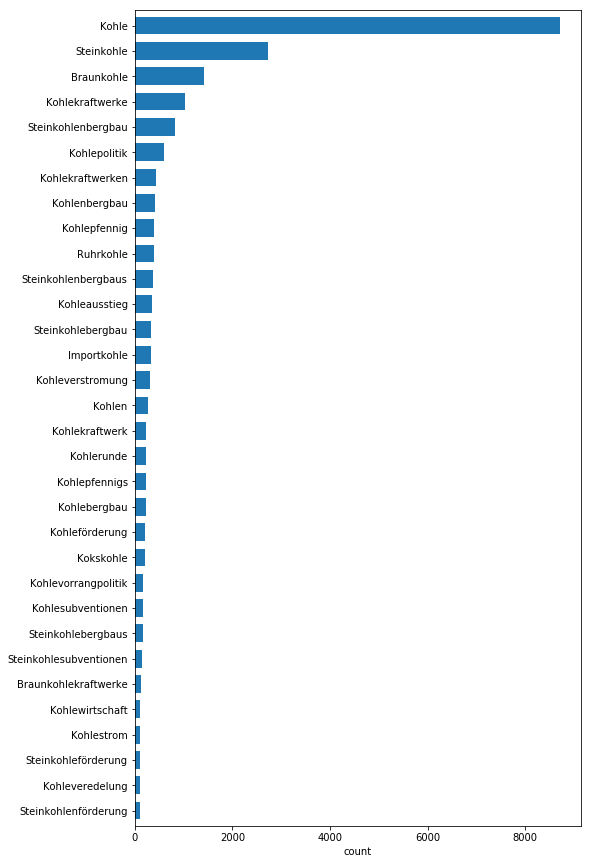

In [48]:
plot_df = count_df[count_df['count'] > 100].set_index('compound').iloc[::-1]
plot_df.plot.barh(figsize=(8,15), width=0.7, legend=False)
plt.xlabel('count')
plt.ylabel('')

# co-occurrance

In [50]:
matched_sentences_withoutnl

['Eigentlich hätte er doch die Steinkohle erwähnen müssen, nicht wahr.',
 'Herr Kollege Fischer, ich wollte mich nur vergewissern, ob ich Sie wirklich richtig verstanden habe: Haben Sie eben zum Ausdruck bringen wollen, daß die der Steinkohle zugesagten Subventionen,\ndaß die Subventionen für die Werften, daß die Subventionen für die deutsche Landwirtschaft allesamt Subventionen für Großverdiener sind?',
 'Die Klientel, die Sie beschützen wollen, hängt in der Tat nicht von Steinkohlesubventionen ab, hängt nicht von Landwirtschaftssubventionen ab -- wobei die Dinge hier schon etwas anders aussehen -- und hängt nicht von Werftensubventionen ab, sondern die hängt davon ab, daß sie nominell hohe Spitzensteuersätze in diesem Lande umgehen kann.',
 'Ich weiß doch, daß Sie die Kohle brauchen, wenn Sie die Kernkraftwerke abschalten wollen.',
 'Jetzt habe ich als Ministerpräsident von Baden-Württemberg wirklich jahrelang darum gekämpft, daß der Kohlepfennig abgeschafft wird.',
 'Herr Teufel, we

In [13]:
import urllib.request
from collections import Counter

import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

data = " ".join(matched_sentences_withoutnl)

stopword_list = stopwords.words("german")

# Note that `ngram_range=(1, 1)` means we want to extract Unigrams, i.e. tokens.
ngram_vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 1), min_df=1, stop_words=stopword_list)
# X matrix where the row represents sentences and column is our one-hot vector for each token in our vocabulary
X = ngram_vectorizer.fit_transform(data.split('\n'))

# Vocabulary
vocab = list(ngram_vectorizer.get_feature_names())

# Column-wise sum of the X matrix.
# It's some crazy numpy syntax that looks horribly unpythonic
# For details, see http://stackoverflow.com/questions/3337301/numpy-matrix-to-array
# and http://stackoverflow.com/questions/13567345/how-to-calculate-the-sum-of-all-columns-of-a-2d-numpy-array-efficiently
counts = X.sum(axis=0).A1

freq_distribution = Counter(dict(zip(vocab, counts)))
for item in freq_distribution.most_common(200):
    print(item)

('kohle', 8724)
('steinkohle', 2733)
('bundesregierung', 2049)
('herr', 1822)
('deutschen', 1712)
('millionen', 1705)
('dass', 1694)
('mehr', 1509)
('braunkohle', 1426)
('dm', 1364)
('müssen', 1242)
('heute', 1181)
('frage', 1128)
('stahl', 1054)
('muß', 1041)
('kohlekraftwerke', 1025)
('deutschland', 1022)
('schon', 982)
('kernenergie', 965)
('deutsche', 957)
('worden', 956)
('sagen', 883)
('jahr', 839)
('steinkohlenbergbau', 821)
('jahre', 792)
('jahren', 770)
('milliarden', 763)
('herren', 752)
('ja', 740)
('wirtschaft', 703)
('damen', 702)
('immer', 666)
('dr', 663)
('fraktion', 660)
('ganz', 654)
('etwa', 627)
('gibt', 616)
('dafür', 615)
('darauf', 614)
('zeit', 614)
('förderung', 613)
('geht', 610)
('neue', 602)
('drucksache', 601)
('gesagt', 601)
('kollege', 598)
('zukunft', 595)
('kohlepolitik', 592)
('wurde', 574)
('maßnahmen', 556)
('nämlich', 556)
('unserer', 548)
('000', 546)
('gerade', 540)
('wissen', 537)
('nordrhein', 533)
('beratung', 532)
('gesetz', 532)
('wäre', 531)

In [15]:
# bigrams
ngram_vectorizer = CountVectorizer(analyzer='word', ngram_range=(2, 2), min_df=1, stop_words=stopword_list)
X = ngram_vectorizer.fit_transform(data.split('\n'))

# Vocabulary
vocab = list(ngram_vectorizer.get_feature_names())

counts = X.sum(axis=0).A1

freq_distribution = Counter(dict(zip(vocab, counts)))
for item in freq_distribution.most_common(200):
    print(item)

('damen herren', 699)
('kohle stahl', 642)
('nordrhein westfalen', 465)
('millionen dm', 455)
('milliarden dm', 450)
('herr kollege', 429)
('millionen tonnen', 421)
('deutsche steinkohle', 274)
('deutschen steinkohle', 262)
('beratung antrags', 235)
('kohle kernenergie', 225)
('weiterer abgeordneter', 217)
('ruhrkohle ag', 216)
('abgeordneter fraktion', 214)
('herr staatssekretär', 204)
('kohle eisen', 204)
('bundesrepublik deutschland', 193)
('erneuerbaren energien', 185)
('milliarden euro', 184)
('deutsche kohle', 177)
('antrags abgeordneten', 169)
('cdu csu', 167)
('eingebrachten entwurfs', 164)
('kohle öl', 161)
('herr bundeswirtschaftsminister', 153)
('entwurfs gesetzes', 147)
('abgeordneten dr', 141)
('erste beratung', 139)
('deutschen steinkohlenbergbaus', 136)
('rufe frage', 133)
('deutschen steinkohlenbergbau', 131)
('heimischen steinkohle', 126)
('deutschen kohle', 123)
('neue kohlekraftwerke', 123)
('überweisungsvorschlag ausschuss', 123)
('eisen stahl', 121)
('pro jahr', 12

# sentence embedding

In [ ]:
# see local script: test pytorch-transformers